In [12]:
# pip install python-dotenv


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import csv
import warnings
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [4]:
# URL to scrape Spotify Daily Chart Totals - South Africa data from
url = 'https://kworb.net/spotify/country/global_daily_totals.html'

# Get the page content
page = requests.get(url)

# Use BeautifulSoup to parse the HTML content
soup = BeautifulSoup(page.text, 'html.parser')

# Get song column headers from the table
song_column_headers = soup.find_all('th')
lst_song_column_headers = [header.text.strip() for header in song_column_headers]

# Get songs data from each row of the table
song_row = soup.find_all('td')
lst_song_row = [song.text.strip() for song in song_row]

# Name of the output CSV file
web_scrape_filename = "top_songs.csv"

# Calculate the number of rows by dividing the total number of data points by the number of columns
num_rows = int(len(lst_song_row) / len(lst_song_column_headers))

start_pt = 0  # Initialize starting point

# Writing data to CSV file
with open(web_scrape_filename, 'w', newline='', encoding='utf-8') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(lst_song_column_headers)

    # Loop through the data and write row by row
    for cnt in range(num_rows):
        new_row = lst_song_row[start_pt:(start_pt + len(lst_song_column_headers))]
        csv_writer.writerow(new_row)
        start_pt += len(lst_song_column_headers)  # Update the starting point for the next row

# Reading the CSV file into a pandas DataFrame
df_web_songs_chart = pd.read_csv(web_scrape_filename)

# Function to convert string numbers with commas to integers
def convert_to_integer(number_string):
    number_string_without_commas = number_string.replace(",", "")
    return int(number_string_without_commas)

# Function to separate song details into title and artist
def separate_song_details(song):
    split_song = song.split(' - ')
    if len(split_song) == 2:
        song_artist = split_song[0]
        song_title = split_song[1]
        return song_title, song_artist
    else:
        return None, song

# Create a new DataFrame for cleaned song chart data
df_top_songs_chart = pd.DataFrame()

# Apply the function to split the 'Artist and Title' into two new columns
df_top_songs_chart[['title', 'artist']] = df_web_songs_chart['Artist and Title'].apply(lambda x: pd.Series(separate_song_details(x)))

# Convert 'Total Streams' column from string to integer
df_top_songs_chart['total_streams'] = df_web_songs_chart['Total'].apply(convert_to_integer)

print("Scraping complete")
print(df_top_songs_chart.head())

Scraping complete
               title                                             artist  \
0    Blinding Lights                                         The Weeknd   
1          As It Was                                       Harry Styles   
2  Someone You Loved                                      Lewis Capaldi   
3       Shape of You                                         Ed Sheeran   
4               None  Post Malone - Sunflower - Spider-Man: Into the...   

   total_streams  
0     4467647511  
1     3566859732  
2     3556027327  
3     3530359352  
4     3422568314  


In [5]:
print(df_top_songs_chart.shape)

(10566, 3)


In [6]:
df_top_songs_chart.columns

Index(['title', 'artist', 'total_streams'], dtype='object')

In [5]:
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# from dotenv import load_dotenv
# import os
# import pandas as pd
# import requests
# from bs4 import BeautifulSoup
# import csv
# import time

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import time

# Load environment variables from .env file
load_dotenv()

# Set your Spotify client credentials directly
client_id = "ed4311c969054dba988e08ae23925d33"
client_secret = "bc0c4418f97645889c0a1a80dfc4c2f4"

if client_id is None or client_secret is None:
    raise Exception("Missing Spotify API credentials. Ensure SPOTIPY_CLIENT_ID and SPOTIPY_CLIENT_SECRET are set.")

# Initialize Spotify API
print("Initializing Spotify API...")
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to search for track and return its ID and artist ID
def search_song(song_title, song_artist):
    query = f'track:{song_title} artist:{song_artist}'
    try:
        result = sp.search(q=query, limit=1)
        if result['tracks']['items']:
            print(f"Found Spotify IDs for: {song_title} by {song_artist}")
            return result['tracks']['items'][0]['id'], result['tracks']['items'][0]['artists'][0]['id']
        else:
            print(f"No results for: {song_title} by {song_artist}")
            return None, None
    except Exception as e:
        print(f"Error occurred while searching for {song_title} by {song_artist}: {e}")
        return None, None

# Function to get audio features for a list of track IDs (batch request)
def get_audio_features_batch(track_ids):
    try:
        audio_features = sp.audio_features(tracks=track_ids)
        print("Fetched audio features for tracks.")
        return audio_features
    except Exception as e:
        print(f"Error occurred while fetching audio features: {e}")
        return []

# Function to get artist information (genre, followers) for a list of artist IDs (batch request)
def get_artist_info_batch(artist_ids):
    try:
        # Validate if artist_ids list is non-empty and contains valid values
        artist_ids = [artist_id for artist_id in artist_ids if pd.notnull(artist_id)]
        
        if len(artist_ids) > 0:
            artist_info = sp.artists(artist_ids)
            print("Fetched artist information.")
            return artist_info['artists']
        else:
            print("No valid artist IDs to fetch.")
            return []
    except Exception as e:
        print(f"Error occurred while fetching artist information: {e}")
        return []

# Web scraping songs in the Spotify South Africa Top 200 Chart
print("Starting web scraping from the Spotify South Africa Top 200 Chart...")
url = 'https://kworb.net/spotify/country/global_daily_totals.html'
try:
    page = requests.get(url, timeout=30)
    soup = BeautifulSoup(page.text, 'html.parser')

    # Get song column headers from the table
    song_column_headers = soup.find_all('th')
    lst_song_column_headers = [header.text.strip() for header in song_column_headers]

    # Get songs data from each row of the table
    song_row = soup.find_all('td')
    lst_song_row = [song.text.strip() for song in song_row]

    # Name of the output CSV file
    web_scrape_filename = "top_songs1.csv"

    # Calculate the number of rows by dividing the total number of data points by the number of columns
    num_rows = int(len(lst_song_row) / len(lst_song_column_headers))

    # Writing data to CSV file
    print("Saving scraped data to CSV...")
    with open(web_scrape_filename, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(lst_song_column_headers)
        start_pt = 0
        for cnt in range(num_rows):
            new_row = lst_song_row[start_pt:(start_pt + len(lst_song_column_headers))]
            csv_writer.writerow(new_row)
            start_pt += len(lst_song_column_headers)

    print("Web scraping completed and data saved to CSV.")

except requests.exceptions.Timeout:
    print("Error: Timeout occurred while trying to scrape the website.")
# Reading the CSV file into a pandas DataFrame
print("Reading data from CSV into DataFrame...")
df_web_songs_chart = pd.read_csv(web_scrape_filename)
print("Data loaded into DataFrame.")

# Limit the data to the first 20 rows
df_web_songs_chart = df_web_songs_chart.head(20)

# Function to convert string numbers with commas to integers
def convert_to_integer(number_string):
    number_string_without_commas = number_string.replace(",", "")
    return int(number_string_without_commas)

# Function to separate song details into title and artist
def separate_song_details(song):
    split_song = song.split(' - ')
    if len(split_song) == 2:
        song_artist = split_song[0]
        song_title = split_song[1]
        return song_title, song_artist
    else:
        return None, song

# Create a new DataFrame for cleaned song chart data
print("Cleaning the scraped data...")
df_top_songs_chart = pd.DataFrame()

# Apply the function to split the 'Artist and Title' into two new columns
df_top_songs_chart[['title', 'artist']] = df_web_songs_chart['Artist and Title'].apply(lambda x: pd.Series(separate_song_details(x)))

# Convert 'Total Streams' column from string to integer
df_top_songs_chart['total_streams'] = df_web_songs_chart['Total'].apply(convert_to_integer)

# Batch Spotify requests
if not df_top_songs_chart.empty:
    df = df_top_songs_chart.copy()

    print("Searching for Spotify IDs...")
    df[['spotify_song_id', 'spotify_artist_id']] = df.apply(lambda row: pd.Series(search_song(row['title'], row['artist'])), axis=1)

    # Drop rows with missing Spotify IDs
    df = df.dropna(subset=['spotify_song_id', 'spotify_artist_id']).reset_index(drop=True)

    # Batch request for audio features
    print("Fetching audio features for all tracks...")
    track_ids = df['spotify_song_id'].tolist()
    audio_features_list = get_audio_features_batch(track_ids)
    audio_features_df = pd.json_normalize(audio_features_list)

    # Batch request for artist information
    print("Fetching artist information for all tracks...")
    artist_ids = df['spotify_artist_id'].tolist()
    artist_info_list = get_artist_info_batch(artist_ids)
    artist_info_df = pd.json_normalize(artist_info_list)

    # Combine data
    print("Combining all fetched data into a final DataFrame...")
    
    # Ensure the columns 'genres' and 'followers' exist
    if 'genres' not in artist_info_df.columns:
        artist_info_df['genres'] = None
    if 'followers.total' not in artist_info_df.columns:
        artist_info_df['followers.total'] = None

    # Now, you can safely create the DataFrame
    df_songs = pd.concat([df, audio_features_df, artist_info_df[['genres', 'followers.total']]], axis=1)
    
    print("Data processing completed.")

else:
    print("DataFrame df_top_songs_chart is empty.")

# Display the final DataFrame
print("Displaying the first few rows of the final DataFrame:")
print(df_songs.head())

Initializing Spotify API...
Starting web scraping from the Spotify South Africa Top 200 Chart...
Saving scraped data to CSV...
Web scraping completed and data saved to CSV.
Reading data from CSV into DataFrame...
Data loaded into DataFrame.
Cleaning the scraped data...
Searching for Spotify IDs...
Found Spotify IDs for: Blinding Lights by The Weeknd
Found Spotify IDs for: As It Was by Harry Styles
Found Spotify IDs for: Someone You Loved by Lewis Capaldi
Found Spotify IDs for: Shape of You by Ed Sheeran
No results for: None by Post Malone - Sunflower - Spider-Man: Into the Spider-Verse
Found Spotify IDs for: Stay by The Kid LAROI
Found Spotify IDs for: Believer by Imagine Dragons
Found Spotify IDs for: lovely by Billie Eilish
Found Spotify IDs for: Heat Waves by Glass Animals
Found Spotify IDs for: Perfect by Ed Sheeran
Found Spotify IDs for: Starboy by The Weeknd
Found Spotify IDs for: Sweater Weather by The Neighbourhood
Found Spotify IDs for: Watermelon Sugar by Harry Styles
Found S

In [8]:
from IPython.display import display  # This is for Jupyter environments
display(df_songs)  # 'df_songs' is the DataFrame you want to display

,title,artist,total_streams,spotify_song_id,spotify_artist_id,danceability,energy,key,loudness,mode,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genres,followers.total
0,Blinding Lights,The Weeknd,4467647511,0VjIjW4GlUZAMYd2vXMi3b,1Xyo4u8uXC1ZmMpatF05PJ,0.513,0.730,1,-5.940,1,...,171.001,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,"[canadian contemporary r&b, canadian pop, pop]",94048849
1,As It Was,Harry Styles,3566859732,4Dvkj6JhhA12EX05fT7y2e,6KImCVD70vtIoJWnq6nGn3,0.520,0.731,6,-5.338,0,...,173.930,audio_features,4Dvkj6JhhA12EX05fT7y2e,spotify:track:4Dvkj6JhhA12EX05fT7y2e,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...,167303,4,[pop],33080787
2,Someone You Loved,Lewis Capaldi,3556027327,7qEHsqek33rTcFNT9PFqLf,4GNC7GD6oZMSxPGyXy4MNB,0.501,0.405,1,-5.679,1,...,109.891,audio_features,7qEHsqek33rTcFNT9PFqLf,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,182161,4,"[pop, uk pop]",12946701
3,Shape of You,Ed Sheeran,3530359352,7qiZfU4dY1lWllzX7mPBI3,6eUKZXaKkcviH0Ku9w2n3V,0.825,0.652,1,-3.183,0,...,95.977,audio_features,7qiZfU4dY1lWllzX7mPBI3,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4,"[pop, singer-songwriter pop, uk pop]",117037818
4,Stay,The Kid LAROI,3174345373,567e29TDzLwZwfDuEpGTwo,2tIP7SsRs7vjIcLrU85W8J,0.591,0.764,1,-5.484,1,...,169.928,audio_features,567e29TDzLwZwfDuEpGTwo,spotify:track:567e29TDzLwZwfDuEpGTwo,https://api.spotify.com/v1/tracks/567e29TDzLwZ...,https://api.spotify.com/v1/audio-analysis/567e...,141806,4,[australian hip hop],5810996
5,Believer,Imagine Dragons,3101880807,0pqnGHJpmpxLKifKRmU6WP,53XhwfbYqKCa1cC15pYq2q,0.776,0.780,10,-4.374,0,...,124.949,audio_features,0pqnGHJpmpxLKifKRmU6WP,spotify:track:0pqnGHJpmpxLKifKRmU6WP,https://api.spotify.com/v1/tracks/0pqnGHJpmpxL...,https://api.spotify.com/v1/audio-analysis/0pqn...,204347,4,"[modern rock, pop, rock]",55134964
6,lovely,Billie Eilish,2949481150,0u2P5u6lvoDfwTYjAADbn4,6qqNVTkY8uBg9cP3Jd7DAH,0.351,0.296,4,-10.109,0,...,115.284,audio_features,0u2P5u6lvoDfwTYjAADbn4,spotify:track:0u2P5u6lvoDfwTYjAADbn4,https://api.spotify.com/v1/tracks/0u2P5u6lvoDf...,https://api.spotify.com/v1/audio-analysis/0u2P...,200186,4,"[art pop, pop]",101851668
7,Heat Waves,Glass Animals,2925005976,3USxtqRwSYz57Ewm6wWRMp,4yvcSjfu4PC0CYQyLy4wSq,0.761,0.525,11,-6.900,1,...,80.870,audio_features,3USxtqRwSYz57Ewm6wWRMp,spotify:track:3USxtqRwSYz57Ewm6wWRMp,https://api.spotify.com/v1/tracks/3USxtqRwSYz5...,https://api.spotify.com/v1/audio-analysis/3USx...,238805,4,"[gauze pop, indietronica, modern rock, pov: in...",4324409
8,Perfect,Ed Sheeran,2864600410,0tgVpDi06FyKpA1z0VMD4v,6eUKZXaKkcviH0Ku9w2n3V,0.599,0.448,8,-6.312,1,...,95.050,audio_features,0tgVpDi06FyKpA1z0VMD4v,spotify:track:0tgVpDi06FyKpA1z0VMD4v,https://api.spotify.com/v1/tracks/0tgVpDi06FyK...,https://api.spotify.com/v1/audio-analysis/0tgV...,263400,3,"[pop, singer-songwriter pop, uk pop]",117037818
9,Starboy,The Weeknd,2762894982,7MXVkk9YMctZqd1Srtv4MB,1Xyo4u8uXC1ZmMpatF05PJ,0.679,0.587,7,-7.015,1,...,186.003,audio_features,7MXVkk9YMctZqd1Srtv4MB,spotify:track:7MXVkk9YMctZqd1Srtv4MB,https://api.spotify.com/v1/tracks/7MXVkk9YMctZ...,https://api.spotify.com/v1/audio-analysis/7MXV...,230453,4,"[canadian contemporary r&b, canadian pop, pop]",94048849


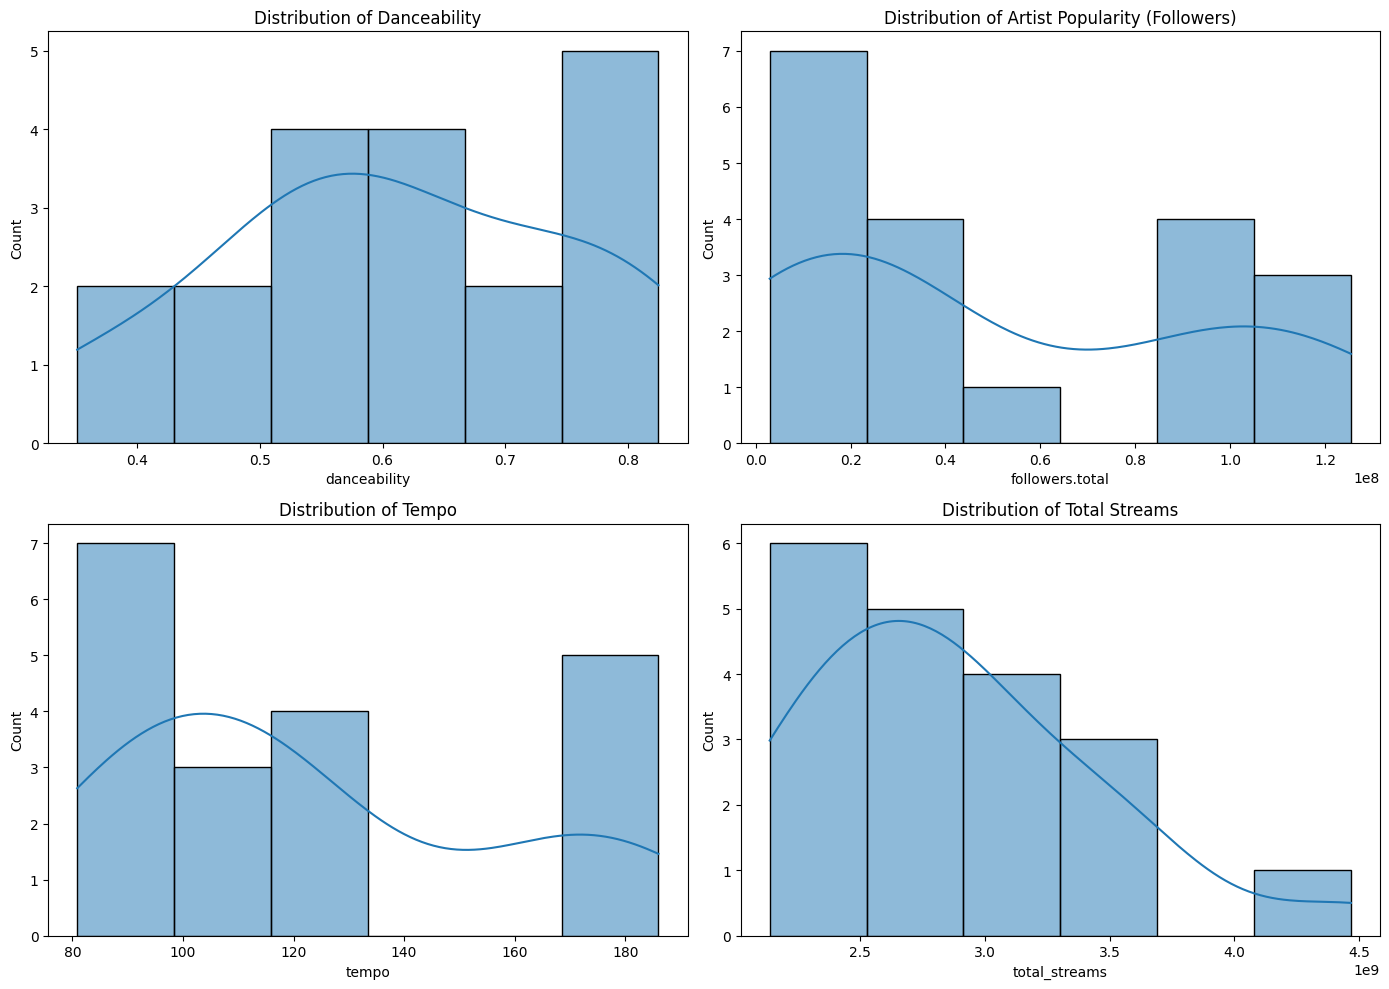

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure for multiple plots
plt.figure(figsize=(14, 10))

# Danceability distribution
plt.subplot(2, 2, 1)
sns.histplot(df_songs['danceability'], kde=True)
plt.title('Distribution of Danceability')

# Artist popularity (followers.total) distribution
plt.subplot(2, 2, 2)
sns.histplot(df_songs['followers.total'], kde=True)
plt.title('Distribution of Artist Popularity (Followers)')

# Tempo distribution
plt.subplot(2, 2, 3)
sns.histplot(df_songs['tempo'], kde=True)
plt.title('Distribution of Tempo')

# Total Streams distribution
plt.subplot(2, 2, 4)
sns.histplot(df_songs['total_streams'], kde=True)
plt.title('Distribution of Total Streams')

plt.tight_layout()
plt.show()

In [11]:
# display(artist_info_df)

In [12]:
# audio_features_df

In [13]:
# df

In [42]:
df_songs.to_csv("20songs.csv")

In [31]:
track_data = sp.track(track_ids)

TypeError: expected string or bytes-like object, got 'list'

In [25]:
len(track_ids)

19

In [17]:
track_data["popularity"]

87

In [41]:
df_songs["track_id"].apply(lambda )

SyntaxError: invalid syntax (2812123190.py, line 1)

In [32]:
def popularity(id):
    return sp.track(id)["popularity"]

In [35]:
popularity(track_ids[0])

87

In [38]:
pop = pd.Series(map(popularity,track_ids))
pop

0     87
1     87
2     85
3     85
4     82
5     85
6     85
7     84
8     85
9     87
10    90
11    82
12    84
13    72
14    84
15    86
16    86
17    86
18    89
dtype: int64

In [39]:
df_songs["popularity"]=pop

In [40]:
df_songs.head()

,title,artist,total_streams,spotify_song_id,spotify_artist_id,danceability,energy,key,loudness,mode,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genres,followers.total,popularity
0,Blinding Lights,The Weeknd,4467647511,0VjIjW4GlUZAMYd2vXMi3b,1Xyo4u8uXC1ZmMpatF05PJ,0.513,0.730,1,-5.940,1,...,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,"[canadian contemporary r&b, canadian pop, pop]",94048849,87
1,As It Was,Harry Styles,3566859732,4Dvkj6JhhA12EX05fT7y2e,6KImCVD70vtIoJWnq6nGn3,0.520,0.731,6,-5.338,0,...,audio_features,4Dvkj6JhhA12EX05fT7y2e,spotify:track:4Dvkj6JhhA12EX05fT7y2e,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...,167303,4,[pop],33080787,87
2,Someone You Loved,Lewis Capaldi,3556027327,7qEHsqek33rTcFNT9PFqLf,4GNC7GD6oZMSxPGyXy4MNB,0.501,0.405,1,-5.679,1,...,audio_features,7qEHsqek33rTcFNT9PFqLf,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,182161,4,"[pop, uk pop]",12946701,85
3,Shape of You,Ed Sheeran,3530359352,7qiZfU4dY1lWllzX7mPBI3,6eUKZXaKkcviH0Ku9w2n3V,0.825,0.652,1,-3.183,0,...,audio_features,7qiZfU4dY1lWllzX7mPBI3,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4,"[pop, singer-songwriter pop, uk pop]",117037818,85
4,Stay,The Kid LAROI,3174345373,567e29TDzLwZwfDuEpGTwo,2tIP7SsRs7vjIcLrU85W8J,0.591,0.764,1,-5.484,1,...,audio_features,567e29TDzLwZwfDuEpGTwo,spotify:track:567e29TDzLwZwfDuEpGTwo,https://api.spotify.com/v1/tracks/567e29TDzLwZ...,https://api.spotify.com/v1/audio-analysis/567e...,141806,4,[australian hip hop],5810996,82
